In [1]:
from modules.utils import TrainConfig, Logger, paint, get_env
from modules.gif_utils import simulate_episode_and_create_gif
from modules.DQN import DQN
from modules.reward import Reward
from modules.preprocess import preprocess

import numpy as np
import pickle
from tqdm.auto import trange

import torch
import torch.nn as nn
import math

import random


import warnings
warnings.filterwarnings('ignore')

import os

# 1 right
# 2 left
# 3 up
# 4 down

# general settings
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_ACTIONS = 5
N_PREDATORS = 5 # change to 5 !!!!!
N_MASKS = 5 # after preprocessing
MAP_SIZE = 40

# train settings
cfg = TrainConfig(
    description='some description',    
    max_steps_for_episode=300, # change to 300 !!!!!
    gamma = 0.9, # maybe better to set less !!!!!
    initial_steps=1000, # change to 100000 !!!!!
    steps=100_000,
    steps_per_update=8,
    steps_per_paint=250,
    steps_per_gif=500,
    buffer_size=10_000,
    batch_size=64,
    learning_rate=1e-3,
    eps_start=0.9, 
    eps_end=0.05,
    eps_decay=1000,
    tau=0.01, # the update rate of the target network, was 0.005
    reward_weights=dict(
        w_d_prey_or_enemy=-0.4,
        w_d_teammate=0.,
        w_d_bonus=0.,
        w_kill_prey=1.,
        w_kill_enemy=3.,
        w_kill_bonus=1.5
    ),
    seed=1234 
)

/Users/maksimkoltugin/Desktop/код/ВШЭ/RL_course_Predators_and_Preys/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TRAIN

In [2]:
# model = DQN(
#     n_masks=N_MASKS,
#     n_actions=N_ACTIONS,
#     n_predators=N_PREDATORS,
#     map_size=MAP_SIZE,
#     device=DEVICE,
#     config=cfg
# ).to(DEVICE).train()

# simulate_episode_and_create_gif(model, 1, N_PREDATORS, cfg, '00000.gif')

In [3]:
# from modules.reward import get_adjacent_cells

# def get_optimal_action(processed_state, x, y):

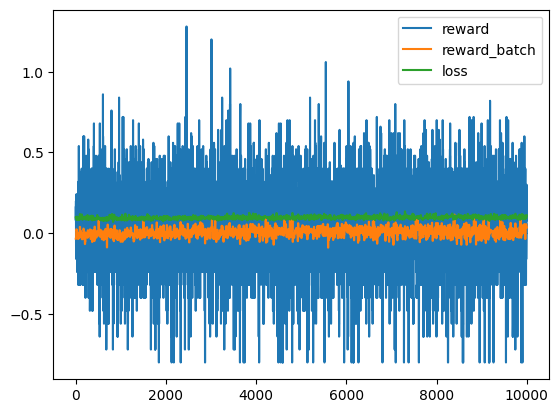

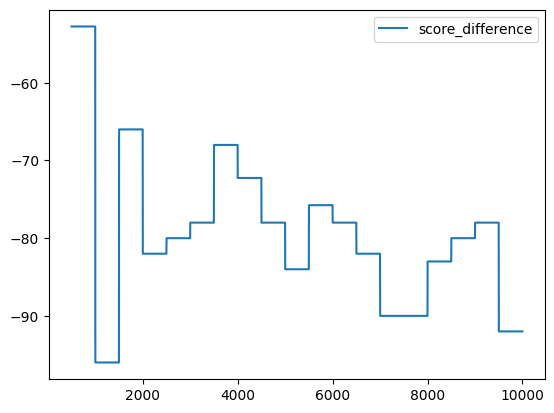

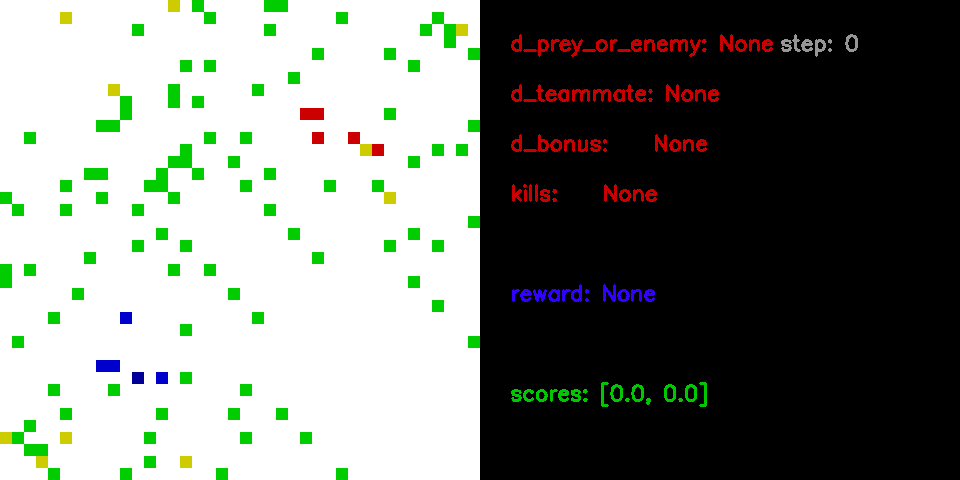

 10%|█         | 10184/100000 [6:04:11<53:31:57,  2.15s/it] 

Training interrupted


In [4]:
def train():
    model = DQN(
        n_masks=N_MASKS,
        n_actions=N_ACTIONS,
        n_predators=N_PREDATORS,
        map_size=MAP_SIZE,
        device=DEVICE,
        config=cfg
    ).to(DEVICE).train()

    logger = Logger(cfg)

    # INITIAL STEPS
    env = get_env(n_predators=N_PREDATORS, difficulty=0, step_limit=cfg.max_steps_for_episode)
    state, info = env.reset()    
    processed_state = preprocess(state, info)
    r = Reward(n_predators=N_PREDATORS, **cfg.reward_weights)
    for _ in trange(cfg.initial_steps):
        actions = model.get_actions(processed_state, random=True)
        next_state, done, next_info = env.step(actions)
        next_processed_state = preprocess(next_state, next_info)
        reward = r(processed_state, info, next_processed_state, next_info)
        model.consume_transition(processed_state, actions, next_processed_state, reward, done)
        state, info = (next_state, next_info) if not done else env.reset()        
        processed_state = preprocess(state, info)
        

    # with open(f'pre_calc_buffer_simple_10000.pkl', 'wb') as handle:
    #     pickle.dump(model.buffer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # TRAINING
    # with open('pre_calc_buffer_simple_10000.pkl', 'rb') as handle:
    #     model.buffer = pickle.load(handle)

    env = get_env(n_predators=N_PREDATORS, difficulty=0, step_limit=cfg.max_steps_for_episode)
    state, info = env.reset()
    processed_state = preprocess(state, info)
    r = Reward(n_predators=N_PREDATORS, **cfg.reward_weights)
    score_difference = None

    try:
        for _ in trange(cfg.steps):
            # ========== step ==========================================================
            eps_threshold = cfg.eps_end + (cfg.eps_start - cfg.eps_end) * \
                math.exp(-1. * model.steps_done / cfg.eps_decay)
            actions = model.get_actions(processed_state, random=(random.random() < eps_threshold))
            next_state, done, next_info = env.step(actions)
            next_processed_state = preprocess(next_state, next_info)
            reward = r(processed_state, info, next_processed_state, next_info)
            model.consume_transition(processed_state, actions, next_processed_state, reward, done)

            if done:
                # not just reset in oreder to implement changes of map
                env = get_env(n_predators=N_PREDATORS, difficulty=model.steps_done/cfg.steps,
                              step_limit=cfg.max_steps_for_episode)
                state, info = env.reset()
            else:
                state, info = next_state, next_info

            processed_state = preprocess(state, info)

            # ========== updates =======================================================
            if model.steps_done % cfg.steps_per_update == 0:
                reward_batch, loss = model.update_policy_network()

            model.soft_update_target_network()  # each step

            if model.steps_done % cfg.steps_per_paint == 0 and model.steps_done > 0:
                paint(logger, [['reward', 'reward_batch', 'loss'], ['score_difference']])

            if model.steps_done % cfg.steps_per_gif == 0 and model.steps_done > 0:
                os.makedirs(logger.curr_subfolder_path + '/gifs', exist_ok=True)
                path = f'{logger.curr_subfolder_path}/gifs/{model.steps_done}_steps.gif'
                score_difference = simulate_episode_and_create_gif(
                    model, model.steps_done/cfg.steps, N_PREDATORS, cfg, path)

            model.steps_done += 1

            # ========== logs ==========================================================
            logger.add('eps', eps_threshold)
            logger.add('reward', reward.mean())
            logger.add('reward_batch', reward_batch)
            logger.add('loss', loss)
            logger.add('score_difference', score_difference)

    except KeyboardInterrupt:
        print('Training interrupted')

    finally:
        logger.save()
        model.save(logger.curr_subfolder_path + f'/model_steps_{model.steps_done}.pt')
        return model


model = train()

# TODO

0. поиграться с тау, весами
0. усложнить сетку ??
0. зафорсить оптимальные действия в инишал буффер ??
0. добавить шедулер ??
1. наказание за простой ??
2. добавить разделение на группы в пейнтр
3. turn on moves
4. добавить MA to paint
5. подготовить систему для смены карт, усложнения карт
6. если заработает бейзлайн, подумать как добавить возм-ть выучить "бфс"

In [ ]:
model = DQN(
    n_masks=N_MASKS,
    n_actions=N_ACTIONS,
    n_predators=N_PREDATORS,
    map_size=MAP_SIZE,
    device=DEVICE,
    config=cfg
).to(DEVICE).train()

with open('pre_calculated_buffer_10000.pkl', 'rb') as handle:
    buffer = pickle.load(handle)